# Descripción de proyecto

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con el cliente basada en datos analíticos. Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes.

Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. La tarea consiste en analizarlos y elaborar una estrategia de retención de clientes. ¿Cómo descubrir si un cliente ya no está contigo? Podemos calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un cliente se haya ido.

Analizaremos los factores que más impactan la pérdida. Predeciremos la probabilidad de pérdida (para el próximo mes) para cada cliente. Seleccionaremos los grupos más destacados y describiremos sus características principales.

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

sns.set_palette(palette='tab10')

In [2]:
# cargamos el archivo 'csv' con los datos\n",
data_gim=pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
data_gim.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
data_gim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

**Model Fitness aportó un archivo CSV que contiene los datos sobre cancelación de un mes en concreto e información del mes que lo precedía. El dataset incluye los siguientes campos**

**'Churn'** — la cancelación para el mes en cuestión
Campos de dataset actuales:

**Datos de usuario del mes anterior**

**'gender'**

**'Near_Location'** — si el usuario vive o trabaja en el vecindario donde se encuentra el gimnasio

**'Partner'** — si el usuario es un trabajador de una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes)

**'Promo_friends'** — si el usuario originalmente se inscribió mediante una oferta "trae a un amigo" (se utilizó el código promocional de un amigo cuando pagaron el primer abono)

**'Phone'** — si el usuario aportó el número de teléfono

**'Age'**
**'Lifetime'** — el tiempo (en meses) desde que el usuario llegó por primera vez al gimnasio

**Datos del registro de visitas y compras y datos sobre el estado actual de la membresía**

**'Contract_period'** — 1 mes, 3 meses, 6 meses o 1 año

**'Month_to_end_contract'** — los meses que faltan hasta que expire el contrato

**'Group_visits'** — si el usuario participa en sesiones grupales

**'Avg_class_frequency_total'** — frecuencia media de visitas por semana a lo largo de la vida del cliente

**Avg_class_frequency_current_month'** — frecuencia media de visitas por semana durante el mes en curso

**'Avg_additional_charges_total'** — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

## Análisis exploratorio de datos

In [5]:
"Revisaremos el dataset en busca de valores nulos o duplicados. Obtendremos estadísticas generales de las variables" 
# revisamos las características de los datos,
print(f'Hay {data_gim.duplicated().sum()} datos duplicados en el dataframe')

Hay 0 datos duplicados en el dataframe


In [6]:
# cambiamos el nombre de las columnas
data_gim.columns=data_gim.columns.str.lower()

In [7]:
# obtenemos estadisticas generales de las variables
data_gim.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


 El rango de edad de las personas que asisten al gimnasio va de los 18 a los 41 años, con un promedio de 29. El 75% de las personas que acuden a ejercitarse no tienen más de 31 años. El promedio de meses de un contrato de membresía es de 4.6 meses. El 30% de los usuarios se inscribieron en compañía de un amigo. El 48% de los usuarios provienen de empresas asociadas al gimnasio.

### Características de los usuarios

In [8]:
 "Veamos las características para los usuarios que se quedaron o cancelaron su contrato."
data_gim.groupby('churn').agg({'mean'})

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [9]:
def grafica_barras(data, var_grouped, var_categorical):
    # agrupamos los datos y obtenemos las frecuencias
    grouped = data.groupby(var_grouped)[var_categorical].value_counts(normalize=True)
    grouped.name = "frecuencia"
    grouped = grouped.to_frame().reset_index()
    
    # creamos la grafica de barras
    f, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=grouped, x=var_grouped, y='frecuencia', hue=var_categorical)

    # Para cada barra: Coloque una etiqueta
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Número de puntos entre barra y etiqueta
        space = 3

        # Use el valor Y como etiqueta y número de formato con cero lugar decimal
        label = "{:.1%}".format(y_value)

        # Crear anotación
        ax.annotate(
            label,                      # Usar `etiqueta` como etiqueta
            (x_value, y_value),         # Coloque la etiqueta al final de la barra
            xytext=(0, space),          # Desplazar etiqueta verticalmente por 'espacio'
            textcoords="offset points", # Interpretar `xytext` como desplazamiento en puntos
            ha='center',                # Etiqueta centrada horizontalmente
            va='bottom', rotation=45
        )
    plt.ylim(0, grouped['frecuencia'].max() * 1.3)
    plt.title('Gráfico ' + var_grouped + ' vs ' + var_categorical)
    plt.legend(title=var_categorical, loc='best')
    plt.show()

#### Gráfica de churn vs gender

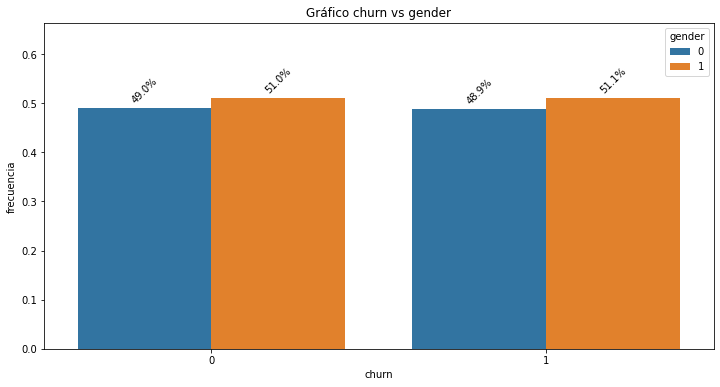

In [10]:
"En esta gráfica vamos a observar el comportamiento de las cancelaciones con respecto al género del usuario."
grafica_barras(data=data_gim,var_grouped='churn',var_categorical='gender')

Podemos observar que de los usuarios que cancelaron su suscripción, el 51.1% de los usuarios son del género 'Masculino'. De los usuarios que mantienen su suscripción, el 51% de los usuarios son del género 'Masculino'. Lo que nos sugiere que el género no influye en la cancelación del plan del usuario.

#### Gráfica de churn vs near_location

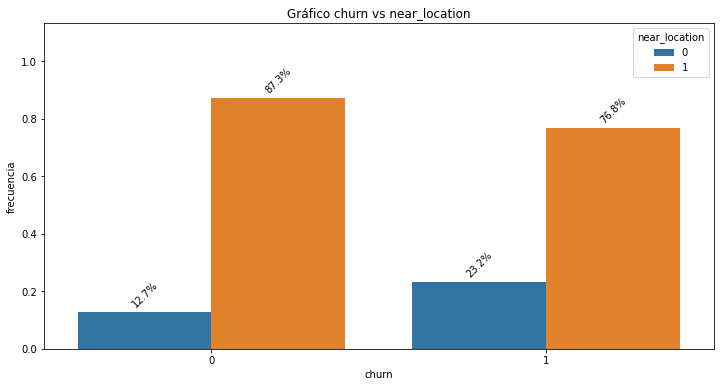

In [11]:
"En esta gráfica vamos a observar el comportamiento de las cancelaciones con respecto a la cercanía del usuario a las instalaciones del gimnasio."
grafica_barras(data=data_gim,var_grouped='churn',var_categorical='near_location')

Podemos observar que de los usuarios que cancelaron su suscripción, el 76.8% de los usuarios se encuentran cerca de las instalaciones del gimnasio. De los usuarios que mantienen su suscripción, el 87.3% de los usuarios se encuentran cerca de las instalaciones del gimnasio.

#### Gráfica de churn vs partner

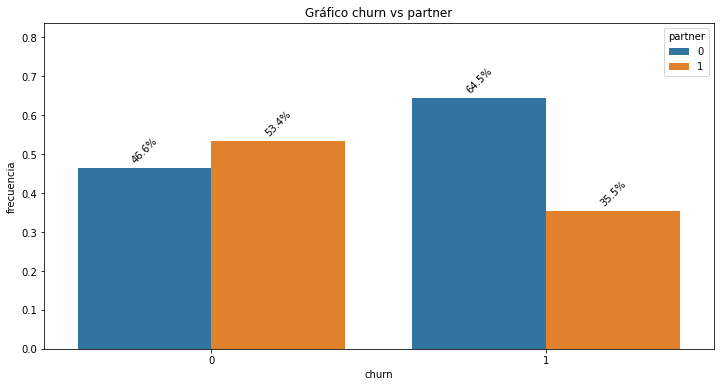

In [12]:
"En esta gráfica vamos a observar el comportamiento de las cancelaciones con respecto a la asociación de alguna empresa con el gimnasio."
grafica_barras(data=data_gim,var_grouped='churn',var_categorical='partner')

Podemos observar que de los usuarios que cancelaron su suscripción, el 64.5% de los usuarios no pertenecen a alguna empresa asociada con el gimnasio. De los usuarios que mantienen su suscripción, el 53.4% de los usuarios pertenecen a alguna empresa asociada al gimnasio.

#### Gráfica de churn vs promo_friends

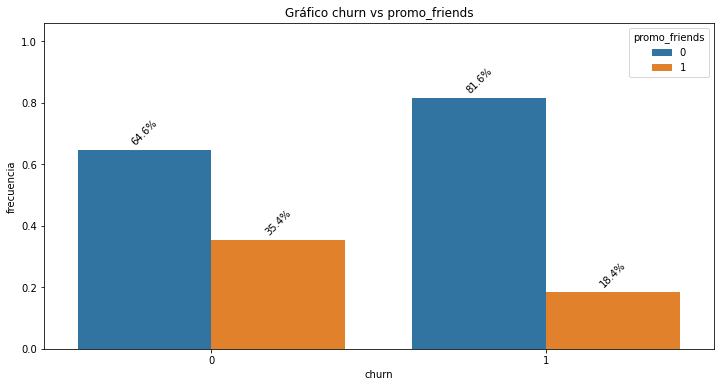

In [13]:
# creamos la grafica de 'churn' vs 'promo_friends'
grafica_barras(data=data_gim,var_grouped='churn',var_categorical='promo_friends')

Podemos observar que de los usuarios que cancelaron su suscripción, el 81.6% de los usuarios se inscribieron sin hacer uso de la promoción \"Inscribete en compañía de un amigo\". De los usuarios que mantienen su suscripción, el 64.6% de los usuarios se inscribieron sin hacer uso de la promoción \"Inscribete en compañía de un amigo

#### Gráfica de churn vs group_visits

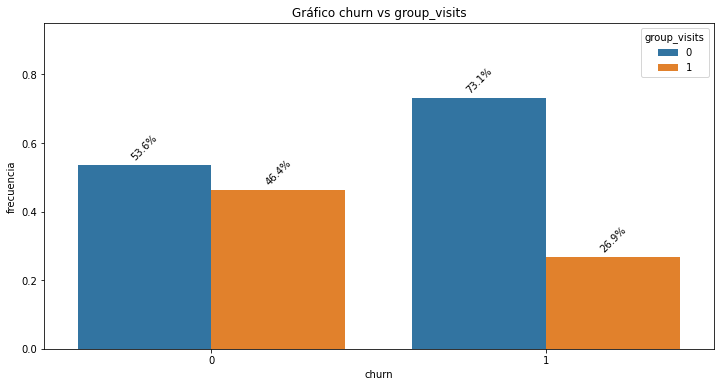

In [14]:
"En esta gráfica vamos a observar el comportamiento de las cancelaciones con respecto a si el usuario participa en sesiones grupales."
grafica_barras(data=data_gim,var_grouped='churn',var_categorical='group_visits')

Podemos observar que de los usuarios que cancelaron su suscripción, el 73.1% de los usuarios no participaron en sesiones grupales. De los usuarios que mantienen su suscripción, el 53.6% de los usuarios no participaron en sesiones grupales.

#### Gráfica de churn vs contract_period

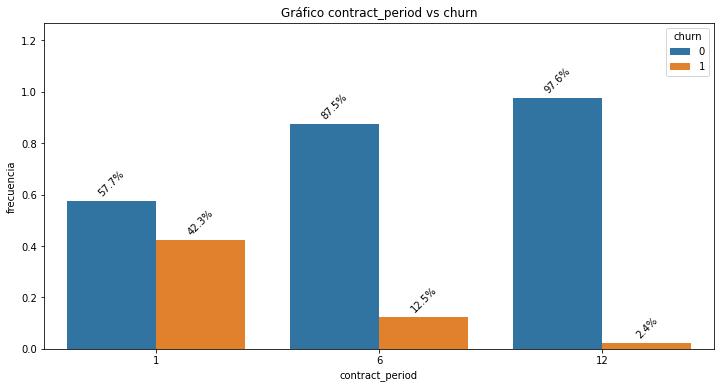

In [15]:
grafica_barras(data=data_gim,var_grouped='contract_period',var_categorical='churn')

Podemos observar que de los usuarios que contrataron un plan por un mes, el 57.7% de los usuarios mantuvieron su plan. De los que contrataron un plan por seis meses, un 87.5% de los usuarios mantuvieron su plan y de los que contrataron un plan por doce meses, el 97.6% de los usuarios mantuvieron su plan. Es decir, mientras mayor sea el tiempo de contratación de un plan mayor es la probabilidad de que el usuario permanezca activo en su plan.

#### Gráfica de churn vs age

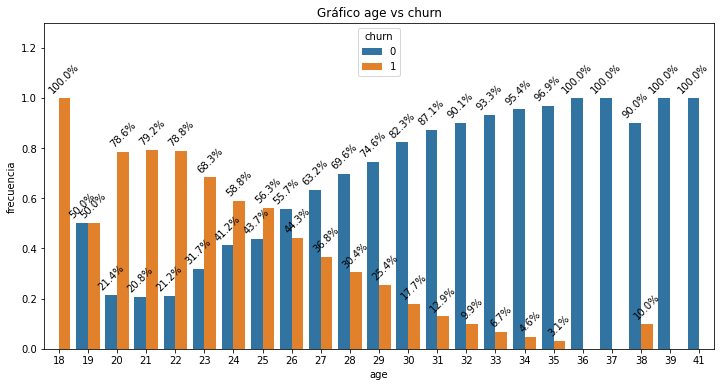

In [16]:
grafica_barras(data=data_gim,var_grouped='age',var_categorical='churn')

Podemos observar que los usuarios más jovenes son los que cancelan su plan en mayor proporción. A partir de los 26 años de edad los usuarios tienden a mantener activo su plan de contratación.

#### Gráfica de churn vs month_to_end_contract

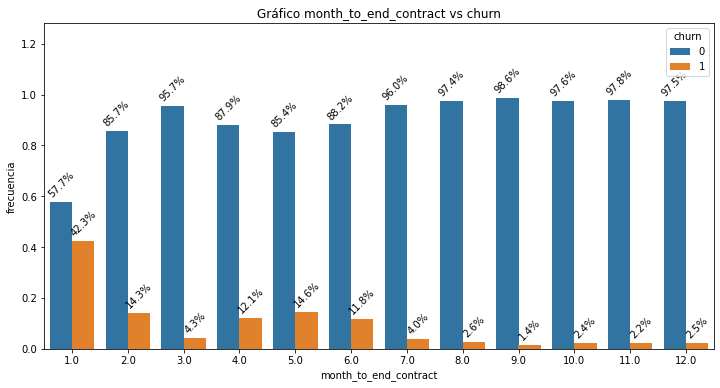

In [17]:
"En esta gráfica vamos a observar el comportamiento de las cancelaciones con respecto a los meses que faltan por terminar el contrato."
grafica_barras(data=data_gim,var_grouped='month_to_end_contract',var_categorical='churn')

Podemos observar que cuando falta un mes para terminar el contrato, el 42.3% de esos usuarios deciden cancelar su plan. Si comparamos este gráfico con el gráfico **'churn' vs 'contract_period'**, podemos inferir que ese porcentaje equivale a los usuarios que realizan la contratación de un plan por un mes.

#### Gráfica de churn vs lifetime

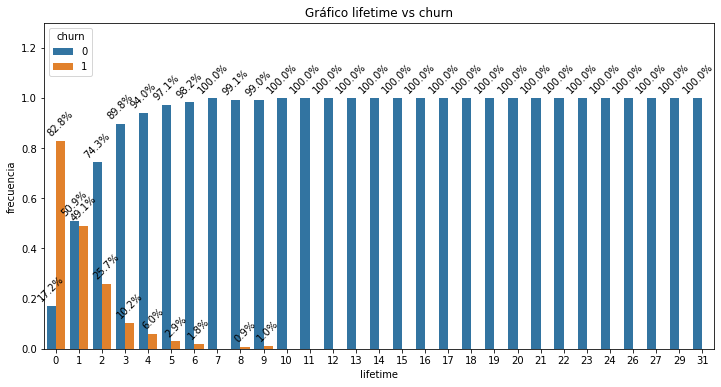

In [18]:
"En esta gráfica vamos a observar el comportamiento de las cancelaciones con respecto a los meses que transcurren desde que el usuario llegó al gimnasio por primera vez."
grafica_barras(data=data_gim,var_grouped='lifetime',var_categorical='churn')

Podemos observar que el 82.8% de los usuarios que no acudieron al gimnasio después de inscribirse cancelaron su suscripción. El 49.1% de los usuarios que acudieron al gimnasio al menos un mes después de inscribirse cancelaron su inscripción. Lo que nos puede estar indicando esta gráfica es que a medida que un usuario acude al gimnasio es menos probable que cancele su suscripción.

#### Gráfica de churn vs 'avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month'

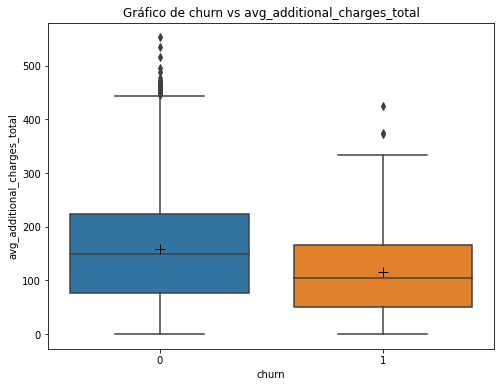

In [19]:
# Creamos una gráfica boxplot para observar el comportamiento de 'churn' vs 'avg_additional_charges_total'
plt.subplots(figsize=(8, 6))
sns.boxplot(data=data_gim, y='avg_additional_charges_total', x='churn', showmeans=True,
            meanprops={"marker": "+", "markeredgecolor": "black", "markersize": 10})
plt.title('Gráfico de churn vs avg_additional_charges_total')
plt.show()

Podemos observar que en promedio (+) los cargos totales adicionales son mayores y con mayor variación en los usuarios que permanecen. Notamos pocos valores outliers cuando los clientes abandonan.

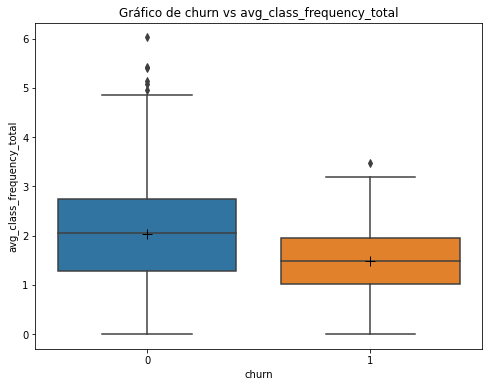

In [20]:
# Creamos una gráfica boxplot para observar el comportamiento de 'churn' vs 'avg_class_frequency_total'
plt.subplots(figsize=(8, 6))
sns.boxplot(data=data_gim, y='avg_class_frequency_total', x='churn', 
            showmeans=True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": 10})
plt.title('Gráfico de churn vs avg_class_frequency_total')
plt.show()

Podemos notar que el promedio de visitas semanales a lo largo de la vida del cliente es mayor y con mayor variación para los clientes que permanecen. El valor medio y mediano para esta variable practicamente coinciden, lo que nos da indicios de una distribución simétrica para esta variable.

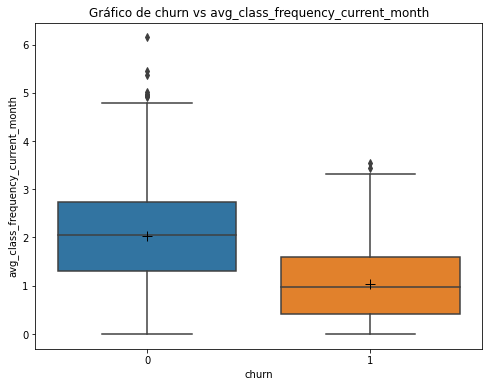

In [21]:
# Creamos una gráfica boxplot para observar el comportamiento de 'churn' vs 'avg_class_frequency_current_month'
plt.subplots(figsize=(8, 6))
sns.boxplot(data=data_gim, y='avg_class_frequency_current_month', x='churn',
            showmeans=True, meanprops={"marker": "+", "markeredgecolor": "black", "markersize": 10})
plt.title('Gráfico de churn vs avg_class_frequency_current_month')
plt.show()

Podemos observar que en promedio los clientes que permanecen tienen más visitas a alguna actividad grupal en el mes corriente, mientras que los clientes que abandonan tienen un promedio más bajo. Entonces, el que un cliente tenga menos actividades grupales puede ser señal que está a punto de abandonar.

In [22]:
# veamos los cargos medios totales por grupo de edad
data_gim.groupby('age')['avg_additional_charges_total'].mean().sort_values(ascending=False)

age
41    310.463578
19    205.780268
39    199.935607
37    185.255342
36    171.543243
35    161.405296
32    156.439473
34    153.885503
30    153.776314
31    151.818854
21    148.049413
20    147.842474
38    147.461398
33    146.865329
27    145.987485
28    143.012268
26    142.558945
29    141.072244
25    139.953211
24    125.724447
23    122.209000
22    119.158200
18     50.069391
Name: avg_additional_charges_total, dtype: float64

Notamos que, **en general, los clientes de mayor edad realizan un mayor gasto en otros servicios del gimnasio.**

Veamos ahora una gráfica de distribución para las variables `'avg_additional_charges_total'`, `'avg_class_frequency_total'` y `'avg_class_frequency_current_month'`, en base a si el usuario canceló o no su plan.

In [25]:
# generamos una lista con las variables a observar su distribución
variables=['avg_additional_charges_total','avg_class_frequency_total','avg_class_frequency_current_month']

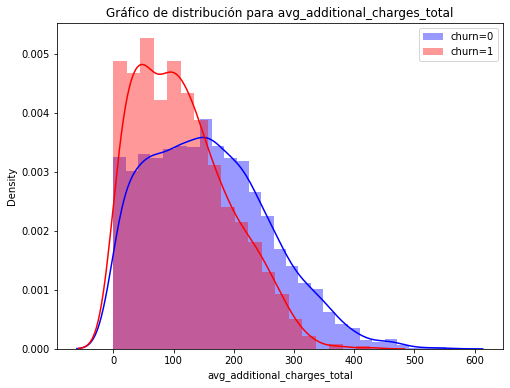

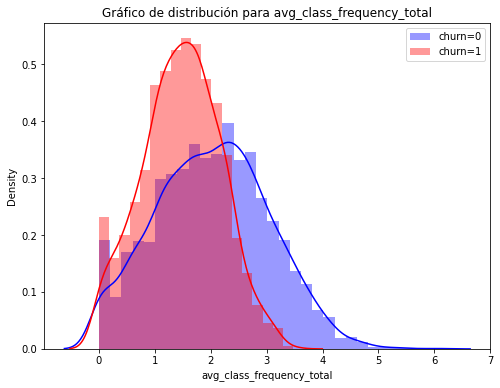

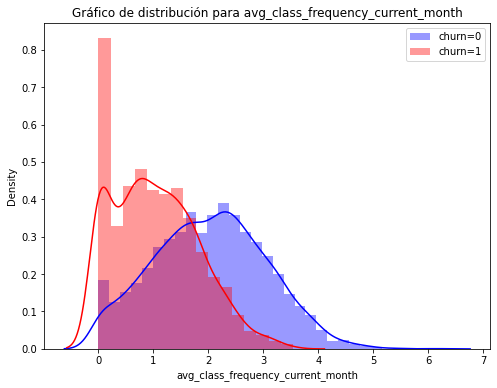

In [26]:
# Creamos los set de datos fuera del bucle
data_1 = data_gim.query('churn == 1')
data_0 = data_gim.query('churn == 0')

# Bucle para graficar cada variable en la lista "variables"
for var in variables:
    # Creamos los gráficos
    f, ax = plt.subplots(figsize=(8, 6))

    # Histograma para los usuarios que terminan su contrato
    sns.distplot(data_0[var], color='blue', label='churn=0')

    # Histograma para los usuarios que cancelan su contrato
    sns.distplot(data_1[var], color='red', label='churn=1')

    plt.title('Gráfico de distribución para ' + var)
    plt.legend(loc='best')
    plt.show()

"Cuando consideramos si el usuario canceló o no su plan, podemos observar que la distribución para cada una de las tres variables no es normal ni parecida."

### Correlación entre variables

En esta sección vamos a estudiar la correlación existente entre las variables bajo estudio. Crearemos un gráfico Heatmap para las variables cuantitativas, pruebas de Chi-cuadrada para las variables cualitativas y pruebas de correlación biserial puntual para la correlación entre variables cuantitativas y cualitativas.

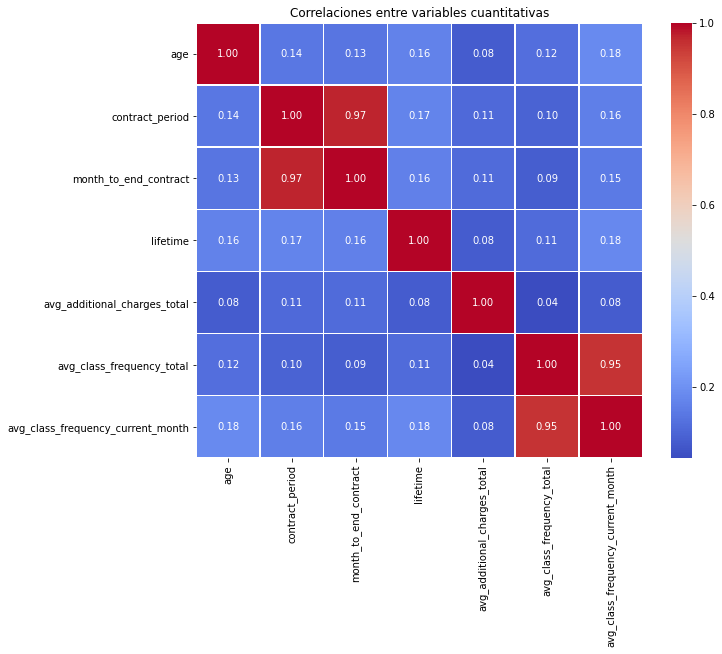

In [27]:
# Creamos la lista de variables para las cuales vamos a crear el heatmap
cuantitativas = ['age', 'contract_period', 'month_to_end_contract', 'lifetime',
                 'avg_additional_charges_total', 'avg_class_frequency_total',
                 'avg_class_frequency_current_month']

# Creamos la matriz de correlación
corrmat = data_gim[cuantitativas].corr()

# Creamos el heatmap para las correlaciones entre variables cuantitativas
plt.figure(figsize=(10, 8))
sns.heatmap(corrmat, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlaciones entre variables cuantitativas')
plt.show()

Podemos notar que las variables `'contract_period'` y `'month_to_end_contract'` presentan una alta correlación. Así mismo, las variables `'avg_class_frequency_total'` y `'avg_class_frequency_current_month'`, también presentan una alta correlación. Esto podría ocasionarnos problemas al momento de ajustar un modelo a los datos.

#### Correlación entre las variables cuantitativas y la variable objetivo `'churn'`

En esta sección vamos a estudiar la correlación existente empleando la función `'pointbiserialr'` del módulo **'scipy.stats'.**

In [28]:
# creamos un dataframe que contenga las correlaciones biseriales entre las variables cuantitativas y la variable objetivo
corr_df=pd.DataFrame(columns=['churn','correlacion'],index=cuantitativas)

In [29]:
# Creamos la lista de variables para las cuales vamos a calcular las correlaciones
cuantitativas = ['age', 'contract_period', 'month_to_end_contract', 'lifetime',
                 'avg_additional_charges_total', 'avg_class_frequency_total',
                 'avg_class_frequency_current_month']

# Creamos un DataFrame para almacenar las correlaciones y su significancia
corr_df = pd.DataFrame(columns=['correlacion', 'es_significativo'], index=cuantitativas)

# Calculamos la matriz de correlaciones
for var_1 in cuantitativas:
    # Obtenemos la correlación y el p-value
    corr, pvalue = st.pointbiserialr(data_gim[var_1], data_gim['churn'])

    # Añadimos el valor al DataFrame y redondeamos la correlación a 3 decimales
    corr_df.loc[var_1, 'correlacion'] = round(corr, 3)

    # Si la correlación es significativa (p-value < 0.05), marcamos como True, de lo contrario, como False
    corr_df.loc[var_1, 'es_significativo'] = pvalue < 0.05

# Mostramos el DataFrame con las correlaciones y su significancia
print(corr_df)

                                  correlacion es_significativo
age                                    -0.405             True
contract_period                         -0.39             True
month_to_end_contract                  -0.381             True
lifetime                               -0.438             True
avg_additional_charges_total           -0.199             True
avg_class_frequency_total               -0.25             True
avg_class_frequency_current_month      -0.412             True


En la tabla anterior, podemos observar que al parecer la variable objetivo si presenta correlación con las variables cuantitativas en el set de datos.

#### Correlación entre las variables cualitativas y la variable objetivo `'churn'`

En esta sección vamos a estudiar la correlación existente entre las variables cualitativas y la variable objetivo `'churn'`, emplearemos la prueba ***'chi-cuadrado'***.

In [37]:
"creamos una lista con las variables cualitativas",
cualitativas=['gender','near_location','partner','promo_friends','phone','group_visits']

In [38]:
# creamos un dataframe que contenga las correlaciones entre las variables cualitativas y la variable objetivo
corr_df=pd.DataFrame(columns=['churn','correlacion'],index=cualitativas)

In [39]:
for var_1 in cualitativas:
    # Obtenemos la tabla de contingencia
    cont_table = pd.crosstab(data_gim['churn'], data_gim[var_1])

    # Realizamos la prueba 'chi-cuadrado'
    res = st.chi2_contingency(cont_table)

    # Añadimos el valor de la prueba al DataFrame
    corr_df.loc[var_1, 'churn'] = res[0]

    # Si no existe independencia entre las variables (p-value < 0.05), marcamos como True, de lo contrario, como False
    corr_df.loc[var_1, 'correlacion'] = res[1] < 0.05

# Mostramos el DataFrame con los resultados de las pruebas 'chi-cuadrado'
print(corr_df)

                    churn correlacion
gender            0.00008       False
near_location   64.836532        True
partner         99.123273        True
promo_friends  104.484146        True
phone             0.00019       False
group_visits   122.149457        True


Al parecer, únicamente las variables de `'gender'` y `'phone'` no parecen tener relación con la variable objetivo `'churn'`.

## Construir un modelo para predecir la cancelación de usuarios


Vamos a construir un modelo de Machine Learning para predecir si un usuario cancelará su suscripción. Dado que este es un problema de clasificación binaria, emplearemos los modelos de Regresión Logística (LogisticRegression) y Clasificador de Bosque Aleatorio (RandomForestClassifier). Además, necesitaremos estandarizar las variables categóricas.

Primeramente veamos la distribución de la variable objetivo 'churn'

In [43]:
# agrupamos por la variable 'churn' y obtenemos sus frecuencias
data_gim['churn'].value_counts(normalize=True)

0    0.73475
1    0.26525
Name: churn, dtype: float64

Podemos observar que el 73.4% de los usuarios cancelaron su plan y solo el 26.6% no cancelaron. Notamos que la variable objetivo no está balanceada.
   ]

In [44]:
# dividimos los datos en características (la matriz X) y una variable objetivo (y)
X=data_gim.drop('churn',axis=1)
y=data_gim['churn']
   

In [45]:
# dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [46]:
# creamos un objeto StandardScaler y lo aplícamos al conjunto de entrenamiento
scaler=StandardScaler()
# seleccionamos las columnas a las cuales les vamos a aplicar la transformacion
cols=['contract_period','age','avg_additional_charges_total','month_to_end_contract','lifetime','avg_class_frequency_total','avg_class_frequency_current_month']

# entrenamos el scaler y transformamos la matriz para el conjunto de entrenamiento\n",
X_train_st=np.concatenate((scaler.fit_transform(X_train[cols]),X_train[X_train.columns.difference(cols)]),axis=1)

In [47]:
# aplicamos la estandarización a la matriz de característica para el test de prueba
X_test_st =np.concatenate((scaler.transform(X_test[cols]),X_test[X_test.columns.difference(cols)]),axis=1)

### Modelo de Regresión Logística

En esta sección vamos a ajustar un modelo de regresión logística a los datos.

In [50]:
# definimos el algoritmo del modelo de regresion logistica\n",
lr_model =LogisticRegression(random_state=0)

# entrenamos el modelo
lr_model.fit(X_train_st,y_train)

# utilizamos el modelo entrenado para hacer previsiones\n",
predictions = lr_model.predict(X_test_st)

# obtenemos la probabilidad de pertenecer a la clase \"0\" o \"1\"\n",
probabilities = lr_model.predict_proba(X_test_st)

In [51]:
# calculamos la exactitud del modelo
lr_accuracy_score=accuracy_score(y_test,predictions)

# calculamos la precision del modelo
lr_precision_score=precision_score(y_test,predictions)

# calculamos el recall del modelo
lr_recall_score=recall_score(y_test,predictions)

In [52]:
# creamos un dataframe para guardar las estadisticas de exactitud, precision y recall para cada modelo
df_estadisticas=pd.DataFrame(columns=['model','accuracy_score','precision_score','recall_score'])

In [53]:
# almacenamos los valores de las estadisticas en el dataframe\n",
df_estadisticas.loc[len(df_estadisticas)]=['LogisticRegression',lr_accuracy_score,lr_precision_score,lr_recall_score]
df_estadisticas

,model,accuracy_score,precision_score,recall_score
0,LogisticRegression,0.92375,0.858639,0.828283


### Modelo de Clasificador de Bosque Aleatorio

En esta sección vamos a ajustar un modelo de Clasificador de Bosque Aleatorio a los datos.

In [54]:
# definimos el algoritmo del modelo clasificador de bosque aleatorio\n",
rfc_model =RandomForestClassifier(random_state=0,n_estimators=100)

# entrenamos el modelo\n",
rfc_model.fit(X_train_st,y_train)

# utilizamos el modelo entrenado para hacer previsiones
y_pred = rfc_model.predict(X_test_st)

In [55]:
# calculamos la exactitud del modelo
rfc_accuracy_score=accuracy_score(y_test,y_pred)

# calculamos la precision del modelo
rfc_precision_score=precision_score(y_test,y_pred)

# calculamos el recall del modelo
rfc_recall_score=recall_score(y_test,y_pred)

In [56]:
# almacenamos los valores de las estadisticas en el dataframe
df_estadisticas.loc[len(df_estadisticas)]=['RandomForestClassifier',rfc_accuracy_score,rfc_precision_score,rfc_recall_score]
df_estadisticas

,model,accuracy_score,precision_score,recall_score
0,LogisticRegression,0.92375,0.858639,0.828283
1,RandomForestClassifier,0.91625,0.846561,0.808081


Podemos notar en la tabla anterior que, **el modelo de Regresión Logística tiene mejor desempeño que el modelo Clasificador de Bosque Aleatorio.** La exactitud, precisión y recall del modelo de Regresión Logística son superiores al modelo alternativo de Bosque Aleatorio.

## Crear clústeres de usuarios
Vamos a construir un modelo de Machine Learning para predecir si un usuario cancelará su suscripción. Emplearemos el algoritmo de K-means. Haremos uso de las variables estandarizadas.

In [57]:
# estandarizamos los datos antes de pasarlos al algoritmo K-means (sin incluir la variable objetivo)
sc = StandardScaler()

# seleccionamos las columnas a las cuales les vamos a aplicar la transformacion
cols=['contract_period','age','avg_additional_charges_total','month_to_end_contract','lifetime','avg_class_frequency_total','avg_class_frequency_current_month']

# entrenamos el scaler y transformamos la matriz para el conjunto de entrenamiento\n",
X_sc=np.concatenate((sc.fit_transform(X[cols]),X[X.columns.difference(cols)]),axis=1)

In [58]:
# establecemos el número de clústeres en 5
km = KMeans(n_clusters = 5,random_state=0)

# aplicamos el algoritmo a los datos y formamos un vector de clúster 
labels = km.fit(X_sc).labels_

In [59]:
# creamos la matriz de distancias para construir el dendograma
linked = linkage(X_sc, method = 'ward')

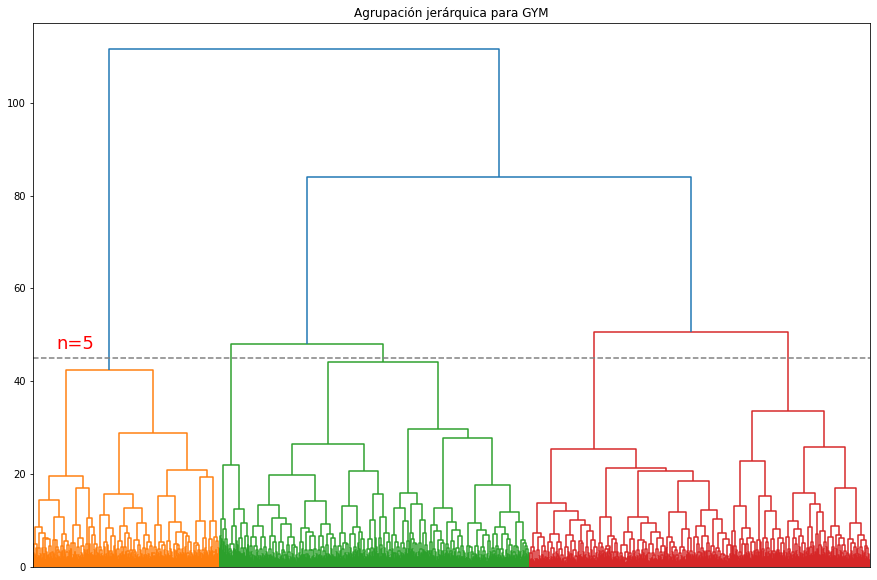

In [60]:
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.axhline(y=45, color='grey', linestyle='dashed')
plt.text(2000, 47, 'n=5', color='red', fontsize=18, ha='center')
plt.xticks([])
plt.title('Agrupación jerárquica para GYM')
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario de Reviewer</b> <a class="tocSkip"></a>

Muy bien, aunque vale la pena notar que con el threshold por defecto, el dendograma sugiere 3 clústers.
</div>

In [61]:
# convertimos el array de clusters en un dataframe
labels_df=pd.DataFrame(labels,columns=['cluster'])

In [62]:
# obtenemos los conteos para cada cluster
labels_df['cluster'].value_counts()

3    1408
1    1066
0     655
4     574
2     297
Name: cluster, dtype: int64

In [63]:
# observamos los valores medios de los clusteres
centroids = km.cluster_centers_
centroids

array([[ 1.01479903,  0.2236759 ,  0.19824795,  1.02318511, -0.06504324,
        -0.90790489, -0.76219921,  0.53435115,  0.49465649,  0.90839695,
         0.67480916,  0.89770992,  0.44427481],
       [-0.44608021,  0.26766297,  0.1039818 , -0.42554206, -0.079471  ,
         0.93223623,  0.95521145,  0.52345216,  0.4108818 ,  0.84333959,
         0.41932458,  0.90712946,  0.28424015],
       [-0.25041287,  0.24625288,  0.01936238, -0.26421418,  2.37270141,
        -0.02295344,  0.09157549,  0.52861953,  0.46127946,  0.87205387,
         0.45117845,  0.86195286,  0.2962963 ],
       [-0.73740258, -0.44742342, -0.23982714, -0.72864207, -0.50687609,
        -0.61099594, -0.73504405,  0.49431818,  0.31178977,  0.77698864,
         0.36079545,  0.90696023,  0.19389205],
       [ 1.60882159,  0.21776764,  0.1589355 ,  1.54676173,  0.23747146,
         0.81535425,  0.85144455,  0.48780488,  0.54181185,  0.93031359,
         0.72473868,  0.91637631,  0.48606272]])

In [64]:
# invertimos el escalamiento para obtener los valores reales de los centroides, las primeras 7 columnas fueron transformadas,
centroids_descaled = scaler.inverse_transform(centroids[:,0:7])
centroids_descaled

array([[  9.31493636,  29.8485872 , 166.48458308,   8.61854743,
          3.48529198,   0.99716376,   0.95940892],
       [  2.66914036,  29.99094595, 157.31975811,   2.55037797,
          3.43066475,   2.78869365,   2.77338391],
       [  3.55926543,  29.92165483, 149.09281521,   3.22611936,
         12.71522351,   1.85873735,   1.86118855],
       [  1.34386375,  27.67665633, 123.89366807,   1.28080682,
          1.81239857,   1.28622923,   0.98809093],
       [ 12.01724923,  29.82946584, 162.66251368,  10.81161161,
          4.63069086,   2.67489937,   2.66378253]])

In [65]:
# creamos un array con los valores reales de los centroides
Z=np.concatenate((centroids_descaled,centroids[:,7:13]),axis=1)

In [66]:
# creamos un dataframe con los valores reales de los centroides
# creamos una lista con los nombres de las columnas del dataframe
columnas=cols+(X[X.columns.difference(cols)].columns.to_list())

centroids_df=pd.DataFrame(Z,columns=columnas)
centroids_df.head()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,gender,group_visits,near_location,partner,phone,promo_friends
0,9.314936,29.848587,166.484583,8.618547,3.485292,0.997164,0.959409,0.534351,0.494656,0.908397,0.674809,0.897710,0.444275
1,2.669140,29.990946,157.319758,2.550378,3.430665,2.788694,2.773384,0.523452,0.410882,0.843340,0.419325,0.907129,0.284240
2,3.559265,29.921655,149.092815,3.226119,12.715224,1.858737,1.861189,0.528620,0.461279,0.872054,0.451178,0.861953,0.296296
3,1.343864,27.676656,123.893668,1.280807,1.812399,1.286229,0.988091,0.494318,0.311790,0.776989,0.360795,0.906960,0.193892
4,12.017249,29.829466,162.662514,10.811612,4.630691,2.674899,2.663783,0.487805,0.541812,0.930314,0.724739,0.916376,0.486063


In [67]:
# vamos a reducir la dimensionalidad del dataset usando PCA
# creamos estimador PCA
pca=PCA(n_components=2,random_state=11)

In [68]:
# ajustamos el modelo
pca.fit(X_sc)

PCA(n_components=2, random_state=11)

In [69]:
# transformamos los datos usando transform
X_pca=pca.transform(X_sc)

In [70]:
# observamos el tamaño del objeto devuelto
X_pca.shape

(4000, 2)

In [71]:
# creamos un dataframe con esos componentes
X_pca_df=pd.DataFrame(X_pca,columns=['componente1','componente2'])

In [72]:
# agregamos la columna de cluster
X_pca_df['cluster']=labels

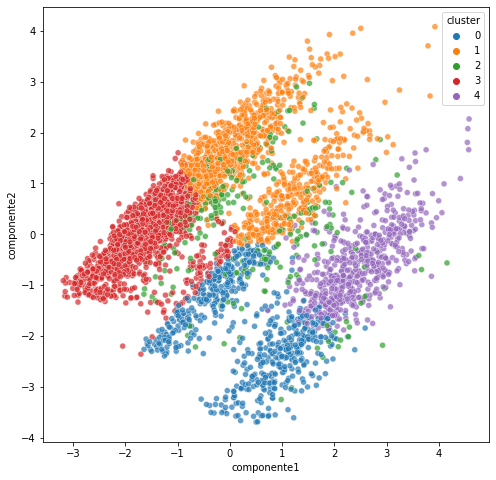

In [73]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=X_pca_df, x='componente1', y='componente2', hue='cluster', alpha=0.7, palette='tab10')
plt.show()

In [74]:
# vamos a crear los centroides usando PCA
centroids_pca=pca.transform(km.cluster_centers_)

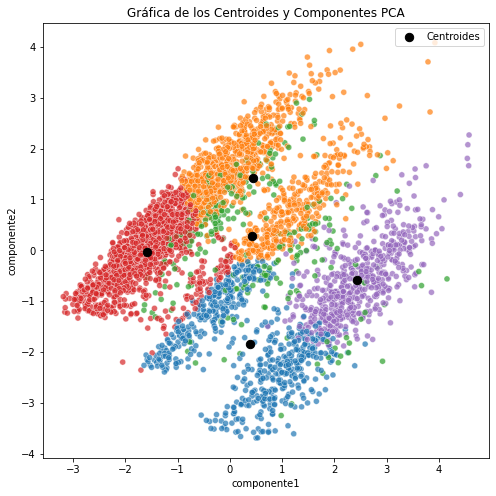

In [75]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=X_pca_df, x='componente1', y='componente2', hue='cluster', alpha=0.7, palette='tab10')
dots = plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=70, c='k')
plt.legend([dots], ['Centroides'], loc='upper right')
plt.title('Gráfica de los Centroides y Componentes PCA')
plt.show()

In [76]:
# obtenemos la métrica para el algoritmo de k-means
# mientras más cercano al valor 1 es mejor
# cercano a cero significa traslape entre clusters
# mientras más cercano a -1 significa peor desempeño
silhouette_score(X_sc, labels)

0.17307860608842218

"En este caso, **el valor cercano a cero de `'silhouette_score'` puede estarnos indicando que hay un posible traslape entre clusters,** lo cual se intuye del gráfico anterior.

**Entrenemos ahora el algoritmo de K-means con k=3,** que son los grupos que parecen estar bien definidos.

In [77]:
# establecemos el número de clústeres en 3
km = KMeans(n_clusters = 3,random_state=0)

# aplicamos el algoritmo a los datos y formamos un vector de clúster
labels = km.fit(X_sc).labels_

In [78]:
# convertimos el array de clusters en un dataframe
labels_df=pd.DataFrame(labels,columns=['cluster'])

In [79]:
# obtenemos los conteos para cada cluster
labels_df['cluster'].value_counts()

2    1765
0    1243
1     992
Name: cluster, dtype: int64

In [81]:
# observamos los valores medios de los clusteres
centroids = km.cluster_centers_
centroids

array([[-0.42050777,  0.27483336,  0.12577531, -0.41315491,  0.29875722,
         0.87214607,  0.90357651,  0.53177796,  0.42156074,  0.84955752,
         0.4151247 ,  0.90345937,  0.27916331],
       [ 1.54899103,  0.21820751,  0.19364224,  1.51610706,  0.29688225,
         0.087895  ,  0.18080614,  0.50907258,  0.54435484,  0.93044355,
         0.71875   ,  0.90423387,  0.48387097],
       [-0.57445209, -0.31619247, -0.19741179, -0.56114824, -0.37725915,
        -0.66360873, -0.73796334,  0.49575071,  0.33144476,  0.79433428,
         0.40679887,  0.90311615,  0.2305949 ]])

In [82]:
# invertimos el escalamiento para obtener los valores reales de los centroides, las primeras 7 columnas fueron transformadas\n",
centroids_descaled = scaler.inverse_transform(centroids[:,0:7])
centroids_descaled

array([[  2.78547386,  30.01415204, 159.4385848 ,   2.60226303,
          4.86273456,   2.73019091,   2.7188457 ],
       [ 11.74506952,  29.83088942, 166.03680254,  10.68321083,
          4.85563545,   1.96665749,   1.95543635],
       [  2.08515413,  28.10136924, 128.01741   ,   1.98237502,
          2.3031618 ,   1.23500632,   0.9850075 ]])

In [83]:
# creamos un array con los valores reales de los centroides
Z=np.concatenate((centroids_descaled,centroids[:,7:13]),axis=1)

In [84]:
# creamos un dataframe con los valores reales de los centroides
# creamos una lista con los nombres de las columnas del dataframe
columnas=cols+(X[X.columns.difference(cols)].columns.to_list())

centroids_df=pd.DataFrame(Z,columns=columnas)
centroids_df.head()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,gender,group_visits,near_location,partner,phone,promo_friends
0,2.785474,30.014152,159.438585,2.602263,4.862735,2.730191,2.718846,0.531778,0.421561,0.849558,0.415125,0.903459,0.279163
1,11.745070,29.830889,166.036803,10.683211,4.855635,1.966657,1.955436,0.509073,0.544355,0.930444,0.718750,0.904234,0.483871
2,2.085154,28.101369,128.017410,1.982375,2.303162,1.235006,0.985008,0.495751,0.331445,0.794334,0.406799,0.903116,0.230595


In [88]:
# vamos a reducir la dimensionalidad del dataset usando PCA
# creamos estimador PCA
pca=PCA(n_components=2,random_state=11)

In [90]:
PCA(n_components=2, random_state=11)

PCA(n_components=2, random_state=11)

In [91]:
pca.fit(X_sc)

PCA(n_components=2, random_state=11)

In [92]:
# transformamos los datos usando transform
X_pca=pca.transform(X_sc)

In [93]:
# observamos el tamaño del objeto devuelto
X_pca.shape

(4000, 2)

In [94]:
# creamos un dataframe con esos componentes
X_pca_df=pd.DataFrame(X_pca,columns=['componente1','componente2'])

In [95]:
# agregamos la columna de cluster 
X_pca_df['cluster']=labels

In [96]:
# vamos a crear los centroides usando PCA
centroids_pca=pca.transform(km.cluster_centers_)

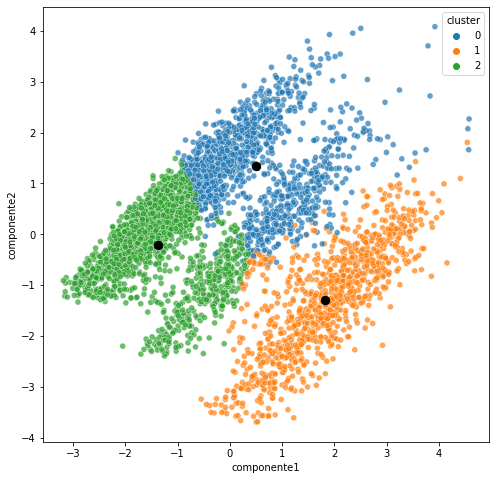

In [97]:
# creamos la grafica de los centroides y los componentes PCA
plt.figure(figsize=(8,8))
sns.scatterplot(data=X_pca_df,x='componente1',y='componente2',hue='cluster',alpha=0.7,palette='tab10')
dots=plt.scatter(centroids_pca[:,0],centroids_pca[:,1],s=70,c='k')
plt.show()

In [98]:
# obtenemos la métrica para el algoritmo de k-means
# mientras más cercano al valor 1 es mejor
# cercano a cero significa traslape entre clusters
# mientras más cercano a -1 significa peor desempeño
silhouette_score(X_sc, labels)

0.19566568435012333

"El valor cercano a cero de la estadística `'silhouette_score'` nos puede indicar que puede existir traslape entre grupos, aunque ya podemos notar una mejor agrupación de los puntos entorno a sus centroides."

In [99]:
# para estudiar la tasa de cancelación en los clusters vamos a unir los clusters con las cancelaciones
concatenado=pd.concat([data_gim['churn'],labels_df['cluster']],axis=1)
concatenado.head()

,churn,cluster
0,0,2
1,0,1
2,0,2
3,0,1
4,0,2


In [100]:
# agrupamos por 'cluster' y obtenemos el porcentaje de cancelación ('churn'=1)
concatenado.groupby('cluster')['churn'].value_counts(normalize=True).map('{:.1%}'.format)

cluster  churn
0        0        92.1%
         1         7.9%
1        0        97.7%
         1         2.3%
2        1        53.3%
         0        46.7%
Name: churn, dtype: object

**Existen diferencias en la tasa de cancelación entre clusters.** Los **clusters más propensos a irse son el cluster número dos y el número cero** con un **53.3% y un 7.9%,** respectivamente.

## Conclusiones y recomendaciones básicas

1. El modelo de Regresión Logística presenta mejor desempeño que el modelo Clasificador de Bosque Aleatorio.
2. El modelo de K-means no parece presentar un buen desempeño en cuanto a la creación de grupos de usuarios. Existe traslape entre los grupos creados. Usando un valor de k=5. Con un valor k=3 parece haber una mejor agrupación, aunque aún existe traslape entre los grupos.
3. Los clusters dos y cero, son los clusters más propensos a cancelar su suscripción al gimnasio.
4. Tanto hombres como mujeres presentan tasas casi iguales de cancelación o permanencia, un 50% aproximadamente. Lo que nos indica que el sexo no es una característica que nos garantice la permanencia de un cliente.
5. Existe un porcentaje alto de usuarios que abandonan el gimnasio aún viviendo cerca, lo que nos dice que la cercanía tampoco es factor para que el usuario no cancele su suscripción.
6. Aproximadamente un tercio de los usuarios que mantienen su suscripción se inscribieron en compañia de un amigo, por lo que podemos lanzar más campañas de este tipo para atraer más clientes.
6. Un alto porcentaje de usuarios que cancelaron su suscripción no participaban de sesiones grupales, así que la participación del usuario en sesiones grupales puede ser un aliciente para permanecer en el gimnasio. Podemos crear más sesiones de este tipo para motivar a los usuarios a permanecer activos en su suscripción.
7. Un alto pocentaje de los usuarios que mantuvieron su suscripción contrataron un plan a partir de seis meses.
8. Los usuarios mayores a 26 años fueron más propensos a mantener su plan activo. Así que podríamos enfocarnos en este segmento de edad para atraer más clientes.
9. Ya que los clientes de mayor edad son los que realizan el mayor gasto adicional en otros servicios del gimnasio, podemos mejorar u ofrecer otros servicios igual de atractivos a esa clase de clientes que pueden pagar dichos servicios.